# TP06 : Logistic Regression

Student names :
- Dan Yvan Baumgartner
- Jan Huber

## Exercice 1 : Classification to predict student admission

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import SGDClassifier

# Load and format training set
df = pd.read_csv('ex1-data-train.csv', header=None)
x1 = df.iloc[:,0]
x2 = df.iloc[:,1]
label = df.iloc[:,2]
df = pd.DataFrame({'x1':x1,'x2':x2,'label':label})

x0 = np.vstack(np.ones(len(x1)))
X = np.append(x0, np.vstack(x1), axis=1)
X = np.append(X, np.vstack(x2), axis=1)
y = label

X_nonlin = np.append(X, np.vstack(x1**2), axis=1)
X_nonlin = np.append(X_nonlin, np.vstack(x2**2), axis=1)

# Load and format data test set
data_test = pd.read_csv('ex1-data-test.csv', header=None)
x1_test = data_test.iloc[:,0]
x2_test = data_test.iloc[:,1]
label_test = data_test.iloc[:,2]
data_test = pd.DataFrame({'x1':x1_test,'x2':x2_test,'label':label_test})

x0_test = np.vstack(np.ones(len(x1_test)))
X_test = np.append(x0_test, np.vstack(x1_test), axis=1)
X_test = np.append(X_test, np.vstack(x2_test), axis=1)
y_test = label_test

X_test_nonlin = np.append(X_test, np.vstack(x1_test**2), axis=1)
X_test_nonlin = np.append(X_test_nonlin, np.vstack(x2_test**2), axis=1)

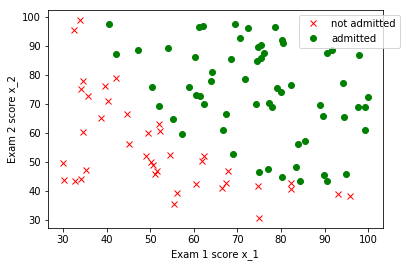

In [19]:
plt.plot(df.loc[df['label']==0,'x1'], df.loc[df['label']==0,'x2'], 'xr', label='not admitted')
plt.plot(df.loc[df['label']==1,'x1'], df.loc[df['label']==1,'x2'], 'og', label='admitted')
plt.xlabel("Exam 1 score x_1")
plt.ylabel("Exam 2 score x_2")
plt.legend(bbox_to_anchor=(0.75, 0.98), loc=2, borderaxespad=0.)
plt.show()

### a. Logistic regression classifier with linear decision boundary

$h_{\theta} = g(\theta_{0} + \theta_{1}x_1 + \theta_{2}x_2)$


**a) Build the design matrix $X$ as follow : $X = 
 \begin{pmatrix}
  1 & x_{1,1} & x_{1,2}\\
  1 & \vdots & \vdots\\
  1 & x_{N,1} & x_{N,2}
 \end{pmatrix}$. Check that the shape of $X$ is (100,3) and that the shape of $y$ is (100,).**

In [20]:
print("X train shape : ", X.shape)
print("y train shape : ", y.shape)
print("X test shape : ", X_test.shape)
print("y test shape : ", y_test.shape)

X train shape :  (100, 3)
y train shape :  (100,)
X test shape :  (100, 3)
y test shape :  (100,)


**b) Implement a z-norm normalization of the training set.**

In [21]:
def zero_norm(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    xZeroNorm = (x-mean)/std
    return xZeroNorm,mean,std


x1_norm,mu_1,sigma_1 = zero_norm(x1)
x2_norm,mu_2,sigma_2 = zero_norm(x2)
x1_sq_norm,mu_1,sigma_1 = zero_norm(x1**2)
x2_sq_norm,mu_2,sigma_2 = zero_norm(x2**2)

X_norm = np.append(x0, np.vstack(x1_norm), axis=1)
X_norm = np.append(X_norm, np.vstack(x2_norm), axis=1)
X_norm_nonlin = np.append(X_norm, np.vstack(x1_sq_norm**2), axis=1)
X_norm_nonlin = np.append(X_norm_nonlin, np.vstack(x2_sq_norm**2), axis=1)



x1_norm,mu_1,sigma_1 = zero_norm(x1_test)
x2_norm,mu_2,sigma_2 = zero_norm(x2_test)
x1_sq_norm,mu_1,sigma_1 = zero_norm(x1_test**2)
x2_sq_norm,mu_2,sigma_2 = zero_norm(x2_test**2)

X_norm_test = np.append(x0, np.vstack(x1_norm), axis=1)
X_norm_test = np.append(X_norm_test, np.vstack(x2_norm), axis=1)
X_norm_test_nonlin = np.append(X_norm_test, np.vstack(x1_sq_norm**2), axis=1)
X_norm_test_nonlin = np.append(X_norm_test_nonlin, np.vstack(x2_sq_norm**2), axis=1)


**c) Implement a sigmoid function $g(z)=\dfrac{1}{1+e^{-z}}$. Check your implementation by plotting the sigmoid function.**

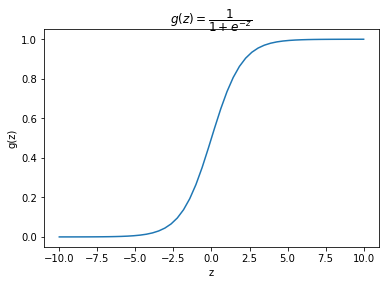

In [22]:
def sigmoid(X):
    sig = 1 / (1 + np.exp(-X))
    return sig


x_sig = np.linspace(-10, 10)
y_sig = sigmoid(x_sig)

plt.plot(x_sig, y_sig)
plt.title('$g(z)=\dfrac{1}{1+e^{-z}}$')
plt.xlabel('z')
plt.ylabel('g(z)')
plt.show()

**d) Implement the hypothesis function $h_\theta({\bf x})$.**

$h_\theta({\bf x}) = g({\bf x} \cdot \theta^T$)

In [23]:
def hypothesis(X, theta):
    # X has shape (N,D) and theta has shape (D,).
    # The dot product is then broadcasted to all samples in X
    return sigmoid(np.dot(X,theta))


**e) Implement the objective function $J(\theta)$.**

$J(\theta)=\dfrac{1}{N}\sum \limits_{n=1}^{N}y_n\log h_\theta( x_n) + (1-y_n)\log(1-h_\theta(x_n))$

In [24]:
def objective(X, y, theta):
    eps = 1e-4
    hyp = hypothesis(X, theta)
    N = len(X)     # number of samples
    J_tmp = y*np.log(hyp+eps) + (1-y)*np.log(1-hyp+eps)
    return np.sum(J_tmp)/N
    

**e) Implement the gradient ascent.**

$\theta_{i} \leftarrow \theta_{i} + \alpha \dfrac{1}{N} \sum \limits_{n=1}^{N}(y_n - h_{\theta}(x_n)) x_{n,i}$

In [25]:
def grad_ascent(X, y, theta, alpha):
    """
    Calculates the next theta
    Should be called in a loop with the desired number of iterations
    """
    n = X.shape[1]
    N = len(X)
    hyp = hypothesis(X, theta)
    
    for i in range(n):
        theta[i] = theta[i] + alpha * (1/N) * np.sum((y - hyp) * X[:, i])
    
    return theta

**g) Test your implementation by running a gradient ascent and plot the evolution of $J(\theta)$.**


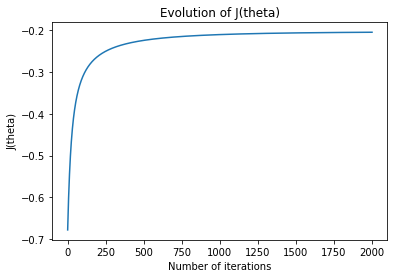

In [26]:
iterations = 2000
alpha = 0.1

theta = np.zeros(X_norm.shape[1])
J_i = np.zeros(iterations)

for i in range(iterations):
    theta = grad_ascent(X_norm, y, theta, alpha)    
    J_i[i] = objective(X_norm, y, theta)

plt.plot(np.linspace(0, iterations, iterations), J_i)
plt.title('Evolution of $J(\\theta)$')
plt.xlabel('Number of iterations')
plt.ylabel('$J(\\theta)$')
plt.show()


**h) Compute the correct classification rate after convergence.**

$P(y_n = 1 | x_n;\theta) = h_{\theta}(x_n)$

$P(y_n = 0 | x_n;\theta) = 1 - h_{\theta}(x_n)$

$\hat{y}=\begin{cases} 
      1, & h_{\theta}(x_n) \geq 0.5 \\
      0, & h_{\theta}(x_n) < 0.5 \\
\end{cases}$

In [27]:
y_hat = np.rint(hypothesis(X_norm, theta))
y_hat_test = np.rint(hypothesis(X_norm_test, theta))

class_rate = np.sum((df['label'].values == y_hat).astype(int))/len(X_norm)
class_rate_test = np.sum((data_test['label'].values == y_hat_test).astype(int))/len(X_norm_test)

print("{}% of the training samples have been correctly classified.".format(class_rate*100))
print("{}% of the test samples have been correctly classified.".format(class_rate_test*100))


89.0% of the training samples have been correctly classified.
90.0% of the test samples have been correctly classified.


**i) Draw the decision boundary of your system on top of the scatter plot of the testing data.**

$\theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0 \implies \theta_1 x_1 + \theta_2 x_2 = -\theta_0$

$x_1 = 0 \rightarrow \theta_2 x_2 = -\theta_0 \implies x_2 = -\dfrac{\theta_0}{\theta_2} \implies (0, -\dfrac{\theta_0}{\theta_2})$

$x_2 = 0 \rightarrow \theta_1 x_1 = -\theta_0 \implies x_1 = -\dfrac{\theta_0}{\theta_1} \implies (-\dfrac{\theta_0}{\theta_1}, 0)$

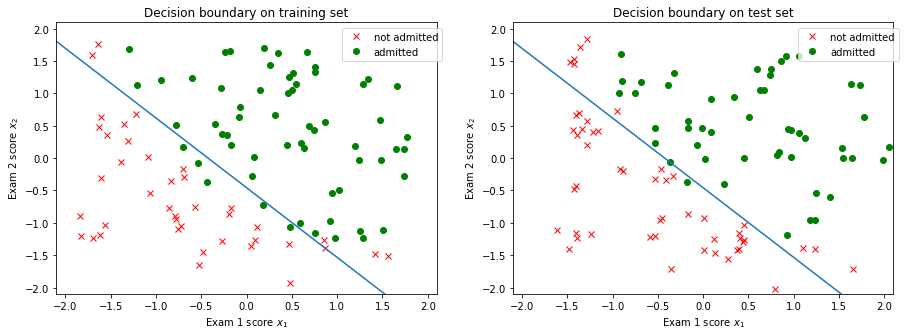

In [28]:
plt.figure(figsize=(15, 5))

df_norm = zero_norm(df[['x1', 'x2']])[0]
df_norm['label'] = pd.Series(df['label'])

data_norm_test = zero_norm(data_test[['x1', 'x2']])[0]
data_norm_test['label'] = pd.Series(data_test['label'])

plt.subplot(1, 2, 1)
plt.plot(df_norm.loc[df_norm['label']==0,'x1'], df_norm.loc[df_norm['label']==0,'x2'], 'xr', label='not admitted')
plt.plot(df_norm.loc[df_norm['label']==1,'x1'], df_norm.loc[df_norm['label']==1,'x2'], 'og', label='admitted')
plt.plot([3, (-theta[0]-3*theta[2])/theta[1]], [(-theta[0]-3*theta[1])/theta[2], 3])
plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)
plt.title("Decision boundary on training set")
plt.xlabel("Exam 1 score $x_1$")
plt.ylabel("Exam 2 score $x_2$")
plt.legend(bbox_to_anchor=(0.75, 0.98), loc=2, borderaxespad=0.)

plt.subplot(1, 2, 2)
plt.plot(data_norm_test.loc[data_norm_test['label']==0,'x1'], data_norm_test.loc[data_norm_test['label']==0,'x2'], 'xr', label='not admitted')
plt.plot(data_norm_test.loc[data_norm_test['label']==1,'x1'], data_norm_test.loc[data_norm_test['label']==1,'x2'], 'og', label='admitted')
plt.plot([3, (-theta[0]-3*theta[2])/theta[1]], [(-theta[0]-3*theta[1])/theta[2], 3])
plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)
plt.title("Decision boundary on test set")
plt.xlabel("Exam 1 score $x_1$")
plt.ylabel("Exam 2 score $x_2$")
plt.legend(bbox_to_anchor=(0.75, 0.98), loc=2, borderaxespad=0.)

plt.show()

**j) Compare the performance of the logistic regression system with the ones of the previous weeks.**

The graph below show the various accuracies of the previous classifiers used. The logistic regression is almost as accurate as the K-nn classifier.

Text(0.5,1,'Accuracy comparison')

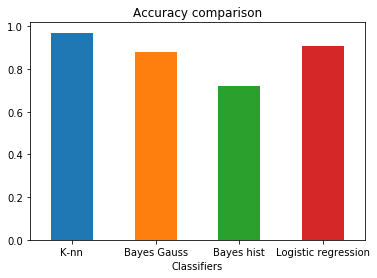

In [35]:
df_comp=pd.DataFrame({'Classifiers':['K-nn', 'Bayes Gauss', 'Bayes hist', 'Logistic regression'], 'Accuracy':[0.97, 0.88, 0.72, 0.91]})
ax = df_comp.plot.bar(x='Classifiers', y='Accuracy', rot=0, legend=False)
ax.set_title('Accuracy comparison')

### c. Logistic regression classifier with non-linear decision boundary

$h_{\theta} = g(\theta_{0} + \theta_{1}x_1 + \theta_{2}x_2 + \theta_{3}x^{2}_{1} + \theta_{4}x^{2}_{2})$

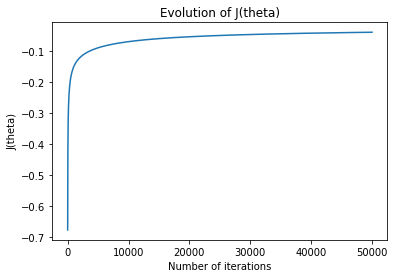

In [30]:
iterations = 50000
alpha = 0.1

theta_nonlin = np.zeros(X_norm_nonlin.shape[1])
J_i_nonlin = np.zeros(iterations)

for i in range(iterations):
    theta_nonlin = grad_ascent(X_norm_nonlin, y, theta_nonlin, alpha)
    J_i_nonlin[i] = objective(X_norm_nonlin, y, theta_nonlin)

plt.plot(np.linspace(0, iterations, iterations), J_i_nonlin)
plt.title('Evolution of $J(\\theta)$')
plt.xlabel('Number of iterations')
plt.ylabel('$J(\\theta)$')
plt.show()

In [34]:
y_hat_nonlin = np.rint(hypothesis(X_norm_nonlin, theta_nonlin))
y_hat_test_nonlin = np.rint(hypothesis(X_norm_test_nonlin, theta_nonlin))

class_rate_nonlin = np.sum((df['label'].values == y_hat_nonlin).astype(int))/len(X_norm_nonlin)
class_rate_test_nonlin = np.sum((data_test['label'].values == y_hat_test_nonlin).astype(int))/len(X_norm_test_nonlin)

print("{}% of the training samples have been correctly classified.".format(class_rate_nonlin*100))
print("{}% of the test samples have been correctly classified.".format(class_rate_test_nonlin*100))

98.0% of the training samples have been correctly classified.
91.0% of the test samples have been correctly classified.


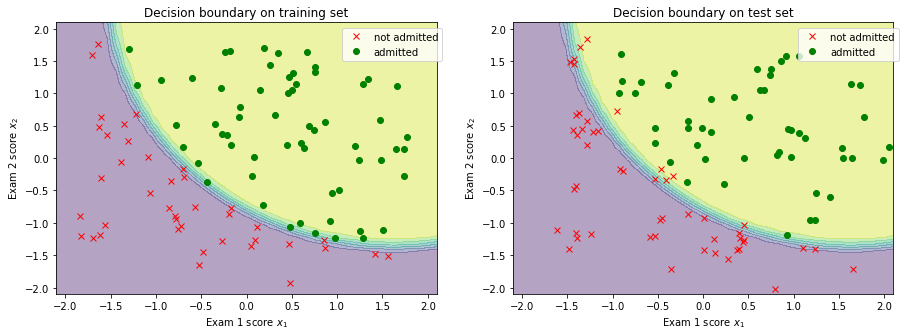

In [38]:
plt.figure(figsize=(15, 5))

df_norm = zero_norm(df[['x1', 'x2']])[0]
df_norm['label'] = pd.Series(df['label'])

data_norm_test = zero_norm(data_test[['x1', 'x2']])[0]
data_norm_test['label'] = pd.Series(data_test['label'])

plt.subplot(1, 2, 1)
x_min, x_max = df_norm.loc[df_norm['label']==0,'x1'].min() - 1, df_norm.loc[df_norm['label']==0,'x1'].max() + 1
y_min, y_max = df_norm.loc[df_norm['label']==0,'x2'].min() - 1, df_norm.loc[df_norm['label']==0,'x2'].max() + 1
dx = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, dx), np.arange(y_min, y_max, dx))
xx2, yy2 = xx*xx, yy*yy
y_hat = hypothesis(np.c_[np.ones(len(xx.ravel())),xx.ravel(), yy.ravel(), xx2.ravel(), yy2.ravel()],theta_nonlin)
y_hat = y_hat.reshape(xx.shape)
plt.contourf(xx, yy, y_hat, alpha=0.4)
plt.plot(df_norm.loc[df_norm['label']==0,'x1'], df_norm.loc[df_norm['label']==0,'x2'], 'xr', label='not admitted')
plt.plot(df_norm.loc[df_norm['label']==1,'x1'], df_norm.loc[df_norm['label']==1,'x2'], 'og', label='admitted')
plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)
plt.title("Decision boundary on training set")
plt.xlabel("Exam 1 score $x_1$")
plt.ylabel("Exam 2 score $x_2$")
plt.legend(bbox_to_anchor=(0.75, 0.98), loc=2, borderaxespad=0.)


plt.subplot(1, 2, 2)
x_min, x_max = data_norm_test.loc[data_norm_test['label']==0,'x1'].min() - 1, data_norm_test.loc[data_norm_test['label']==0,'x1'].max() + 1
y_min, y_max = data_norm_test.loc[data_norm_test['label']==0,'x2'].min() - 1, data_norm_test.loc[data_norm_test['label']==0,'x2'].max() + 1
dx = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, dx), np.arange(y_min, y_max, dx))
xx2, yy2 = xx*xx, yy*yy
y_hat = hypothesis(np.c_[np.ones(len(xx.ravel())),xx.ravel(), yy.ravel(), xx2.ravel(), yy2.ravel()],theta_nonlin)
y_hat = y_hat.reshape(xx.shape)
plt.contourf(xx, yy, y_hat, alpha=0.4)
plt.plot(data_norm_test.loc[data_norm_test['label']==0,'x1'], data_norm_test.loc[data_norm_test['label']==0,'x2'], 'xr', label='not admitted')
plt.plot(data_norm_test.loc[data_norm_test['label']==1,'x1'], data_norm_test.loc[data_norm_test['label']==1,'x2'], 'og', label='admitted')
plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)
plt.title("Decision boundary on test set")
plt.xlabel("Exam 1 score $x_1$")
plt.ylabel("Exam 2 score $x_2$")
plt.legend(bbox_to_anchor=(0.75, 0.98), loc=2, borderaxespad=0.)

plt.show()

### d. Using SciKit Learn

In [39]:
clf = SGDClassifier(loss="log", max_iter=100000)
clf.fit(X_norm[:, [1,2]], y)

y_hat = clf.predict(X_norm[:, [1,2]])
y_hat_test = clf.predict(X_norm_test[:, [1,2]])

class_rate = np.sum((df['label'].values == y_hat).astype(int))/len(X_norm)
class_rate_test = np.sum((data_test['label'].values == y_hat_test).astype(int))/len(X_norm_test)

print("{}% of the training samples have been correctly classified.".format(class_rate*100))
print("{}% of the test samples have been correctly classified.".format(class_rate_test*100))


89.0% of the training samples have been correctly classified.
90.0% of the test samples have been correctly classified.


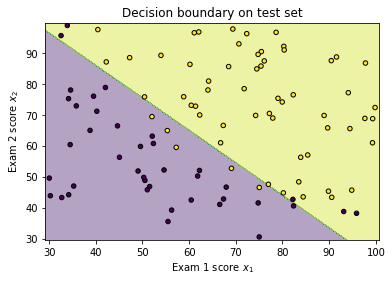

In [40]:
clf = SGDClassifier(loss="log", max_iter=100000)
clf.fit(X[:, [1,2]], y)

x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

y_hat = clf.predict(np.c_[xx.ravel(), yy.ravel()])
y_hat = y_hat.reshape(xx.shape)

plt.contourf(xx, yy, y_hat, alpha=0.4)
plt.scatter(X[:, 1], X[:, 2], c=y, s=20, edgecolor='k')
plt.title("Decision boundary on test set")
plt.xlabel("Exam 1 score $x_1$")
plt.ylabel("Exam 2 score $x_2$")
plt.show()

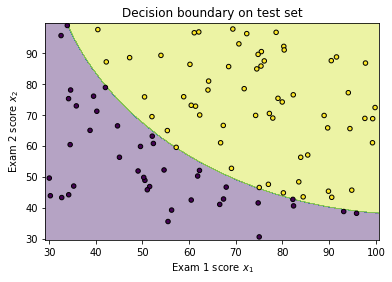

In [41]:
clf = SGDClassifier(loss="log", max_iter=10000000)
clf.fit(X_nonlin[:, [1,2,3,4]], y)

x_min, x_max = X_nonlin[:, 1].min() - 1, X_nonlin[:, 1].max() + 1
y_min, y_max = X_nonlin[:, 2].min() - 1, X_nonlin[:, 2].max() + 1
dx = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, dx), np.arange(y_min, y_max, dx))
xx2, yy2 = xx*xx, yy*yy
y_hat = clf.predict(np.c_[xx.ravel(), yy.ravel(), xx2.ravel(), yy2.ravel()])
y_hat = y_hat.reshape(xx.shape)

plt.contourf(xx, yy, y_hat, alpha=0.4)
plt.scatter(X_nonlin[:, 1], X_nonlin[:, 2], c=y, s=20, edgecolor='k')
plt.title("Decision boundary on test set")
plt.xlabel("Exam 1 score $x_1$")
plt.ylabel("Exam 2 score $x_2$")
plt.show()